In [2]:
from datascience import *
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import Image, display
import ipywidgets as widgets
from scipy import stats
%matplotlib inline

# Tables 

For a collection of things in the world, an array is useful for describing a single attribute of each thing. For example, among the collection of US States, an array could describe the land area of each. Tables extend this idea by describing multiple attributes for each element of a collection.

In most data science applications, we have data about many entities, but we also have several kinds of data about each entity.

When we import data later in this lab, it will import into a table format.

### Analyzing datasets
With just a few table methods, we can answer some interesting questions about datasets.

We can extract single columns, which are arrays themselves, and do math on them (averaging, max, min, etc), which we'll do on real data soon. We can also rearrange the order of rows in a table by the values in any column, add more rows or columns, filter tables to select only rows that meet certain criteria, and much more!

### Tables Essentials!

For your reference, here's a table of all the functions and methods we saw in this lab.

|Name|Example|Purpose|
|-|-|-|
|`Table`|`Table()`|Create an empty table, usually to extend with data|
|`Table.read_table`|`Table.read_table("my_data.csv")`|Create a table from a data file|
|`with_columns`|`tbl = Table().with_columns("N", np.arange(5), "2*N", np.arange(0, 10, 2))`|Create a copy of a table with more columns|
|`column`|`tbl.column("N")`|Create an array containing the elements of a column|
|`sort`|`tbl.sort("N")`|Create a copy of a table sorted by the values in a column|
|`where`|`tbl.where("N", are.above(2))`|Create a copy of a table with only the rows that match some *predicate*|
|`num_rows`|`tbl.num_rows`|Compute the number of rows in a table|
|`num_columns`|`tbl.num_columns`|Compute the number of columns in a table|
|`select`|`tbl.select("N")`|Create a copy of a table with only some of the columns|
|`drop`|`tbl.drop("2*N")`|Create a copy of a table without some of the columns|
|`take`|`tbl.take(np.arange(0, 6, 2))`|Create a copy of the table with only the rows whose indices are in the given array|


---

# UC Berkeley

We're going to start right here at UCB! These data are from Fall 2015.

*Source: UC Corporate Personnel System*

**Note**: STEM includes engineering and computer science, life sciences, math, medicine, other health sciences and physical sciences.

Let's read in a CSV file. A CSV file is a common storage device for spreadsheet data and is also easily manipulated and exported by using programs like Excel.

These data will give us the ratio of female ladder rank equivalent (LRE), which are tenure and tenure track faculty at Berkeley, in the respective divisions.

In [80]:
UCB_LRE_female = Table.read_table('data/UCB-percent-female-LRE.csv').drop(1)
UCB_LRE_female.show()

Discipline,Fall 2000,Fall 2005,Fall 2010,Fall 2015
Intdisc & Other,0.39,0.42,0.45,0.43
Arts & Humanities,0.37,0.41,0.43,0.45
Oth Health Sci,0.35,0.39,0.45,0.44
Soc Sci & Psych,0.3,0.35,0.38,0.41
Professional,0.29,0.33,0.37,0.38
Life Sci (STEM),0.2,0.23,0.25,0.29
Medicine,0.15,0.18,0.2,0.25
Phys Sci/Math (STEM),0.1,0.13,0.17,0.18
Eng & CS (STEM),0.08,0.11,0.14,0.16


We can quickly plot these data on a bar graph, so that we can best visually compare between disciplines over time.

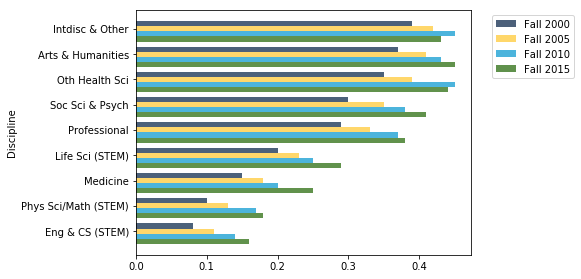

In [81]:
UCB_LRE_female.barh('Discipline')

What do you notice about the proportions of female LRE faculty across disciplines? Discuss with the people around you, and write a few sentences about it below. 

> Type your response here.

---

We see in other published materials that over the ten year period there has been an increase in underrepresented minorities at UCB:

<img src="data/gender_subject.png" alt="gender_subject" style="width: 400px;"/>

The increase in the share of ladder-rank and equivalent (LRE) faculty who are underrepresented minorities has largely been due to an increase in the Hispanic/Latino(a) group. Representation by American Indian and African American faculty remains a challenge.

Female LRE faculty have grown in share over time, fueled by increased diversity in hiring. Their proportion differs significantly depending on discipline.

<img src="data/subject_line_graph.png" alt="subject_line_graph" style="width: 400px;"/>



---

## UCOP Payroll Dataset

Let's look at another dataset that has the payroll for all UC empoloyees:

In [82]:
UCB_data = Table.read_table('data/UCOP.csv')
UCB_data.show(5)

Year,Location,First Name,Last Name,Title,Gross Pay,Regular Pay,Overtime Pay,Other Pay
2015,Berkeley,BARIKA,BURTON,ACAD ACHIEVEMENT CNSLR 2,54861,52541,0,2320
2015,Berkeley,MAYRA,GONZALEZ,ACAD ACHIEVEMENT CNSLR 2,51624,51624,0,0
2015,Berkeley,DIANA,FLORES,ACAD ACHIEVEMENT CNSLR 2,48880,47593,787,500
2015,Berkeley,KATHERINE,CASTRO,ACAD ACHIEVEMENT CNSLR 2,48646,48371,275,0
2015,Berkeley,LILIANA,IGLESIAS,ACAD ACHIEVEMENT CNSLR 2,47080,47080,0,0


Let's look only at professors:

In [83]:
rd = UCB_data.select(2,3,4,5).sort(3, descending=True)
professors = rd.where("Title", are.equal_to("PROF-AY"))
professors.show(5)

First Name,Last Name,Title,Gross Pay
STEPHEN,SHORTELL,PROF-AY,465004
ROBERT,BIRGENEAU,PROF-AY,451845
BIN,YU,PROF-AY,382058
OMAR,YAGHI,PROF-AY,368771
MARK,D'ESPOSITO,PROF-AY,363704


Big money!

We can visualize the distribution of pay with a histogram, but the histogram (counting frequencies of a specific pay level) will change depending upon the "bin size" of these pay levels. We can make an interactive slider to see this:

In [84]:
def hist_bins(bin_size=1):
    professors.select(3).hist(bins=np.arange(0,500000,bin_size*2000))

slider = widgets.IntSlider(min=1,max=10,step=1,value=5)
display(widgets.interactive(hist_bins, bin_size=slider))

interactive(children=(IntSlider(value=5, description='bin_size', max=10, min=1), Output()), _dom_classes=('widget-interact',))

What are the drawbacks and advantages of different bin sizes?

> Type your response here.

### Salary for males vs. females on the UC payroll

While we don't have gender data in this dataset, we can use a pre-trained machine learning model to predict gender based on first name (we will forget for a moment that creating binary categories of male and female is problematic to begin with). While this is ***certainly not 100% accurate***, it is more like around 80%, we can use it to get a better idea of salaries for different genders.

In [85]:
!pip install nltk

In [86]:
!pip install nltk.corpus

  Could not find a version that satisfies the requirement nltk.corpus (from versions: )
No matching distribution found for nltk.corpus


Here is an example of what the classification model can do:

In [91]:
from scripts.gender import classify_gender

classify_gender("Daniel"), classify_gender("Katherine")

('MALE', 'FEMALE')

We can add a new column to our professors table with the gender classification output by the model for each professor's name.

In [92]:
professors.append_column("Gender", [classify_gender(name) for name in professors['First Name']])
professors.show(5)

First Name,Last Name,Title,Gross Pay,Gender
STEPHEN,SHORTELL,PROF-AY,465004,MALE
ROBERT,BIRGENEAU,PROF-AY,451845,MALE
BIN,YU,PROF-AY,382058,MALE
OMAR,YAGHI,PROF-AY,368771,MALE
MARK,D'ESPOSITO,PROF-AY,363704,MALE


Now let's investigate the average salary amounts for female vs. male professors:

In [93]:
professors.to_df().groupby(['Gender'])['Gross Pay'].mean()

Gender
FEMALE    158435
MALE      185467
Name: Gross Pay, dtype: int64

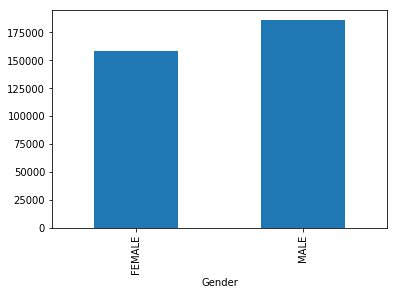

In [94]:
professors.to_df().groupby(['Gender'])['Gross Pay'].mean().plot.bar()

What can we conclude from this analysis?

---

## Silicon Valley

These data are compiled from EEO-1 reports from Apple, Twitter, Salesforce, Facebook, Microsoft, and Intel. The EEO-1 is a document required by the federal government that provides the raw numbers of employees in each of the categories below. We summed the most recent data (all from 2014-16) for these companies to get the table below.

In [95]:
tech_data = Table.read_table('data/eeo-aggregate.csv')
tech_data.show()

Job Categories,Hispanic or Latino Male,Hispanic or Latino Female,White Male,Black or African American Male,Native Hawaiian or Pacific Islander Male,Asian Male,American Indian or Alaska Native Male,Two or More Races Male,White Female,Black or African American Female,Native Hawaiian or Pacific Islander Female,Asian Female,American Indian or Alaska Native Female,Two or More Races Female,All Male,All Female
Executive/Senior Officials and Managers,21,21,554,10,1,117,2,6,140,4,0,34,0,2,1422,402
First/mid Officials and Managers,1160,1160,14628,494,31,5320,71,197,4807,245,21,1640,13,95,43802,15962
Professionals,4789,4789,50183,2330,165,33459,325,1200,14440,1034,77,12771,118,546,184902,67550
Technicians,2868,2868,12444,1891,93,1585,159,414,3314,1296,32,576,49,233,38908,16736
Sales Workers,3008,3008,13491,2349,125,1559,68,502,5807,1268,62,896,42,310,42204,22786
Administrative Support,703,703,2140,358,31,411,14,90,3339,530,40,762,34,155,7494,11126
Craft Workers,89,89,398,26,0,34,9,7,23,3,0,2,2,0,1126,238
Operatives,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Laborers and Helpers,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0
Service Workers,133,133,76,12,6,46,1,6,27,12,2,16,0,3,560,386


We can look at a basic bar chart of all males and females by job category:

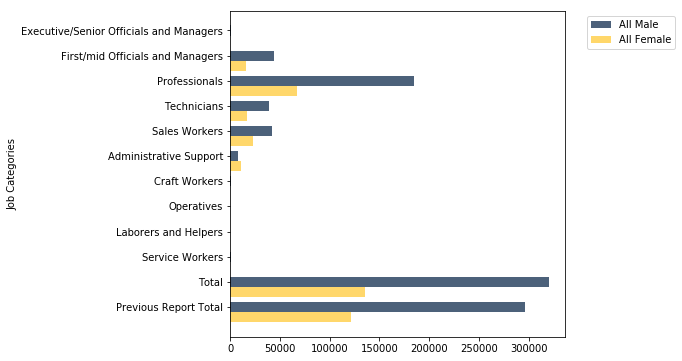

In [96]:
tech_data.select(['Job Categories', 'All Male', 'All Female']).barh('Job Categories')

We can also break down each gender by race:

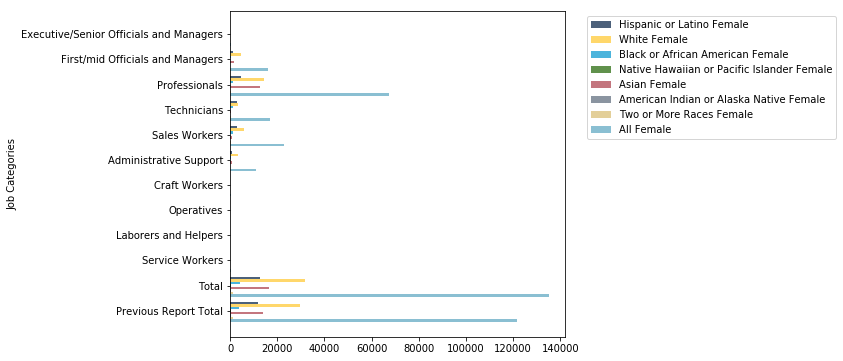

In [97]:
females = [c for c in tech_data.to_df().columns if "Female" in c]
tech_data.select(['Job Categories'] + females).barh('Job Categories')

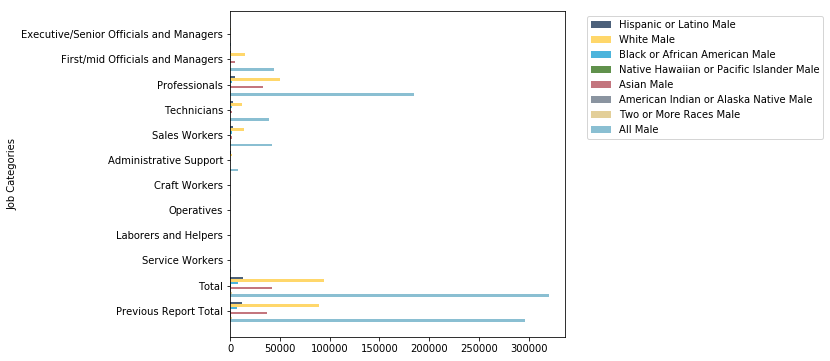

In [98]:
males = [c for c in tech_data.to_df().columns if "Male" in c]
tech_data.select(['Job Categories'] + males).barh('Job Categories')

What do you see in this data? (**Note**: It might be a little hard to see since the bars are so small - zoom in!)

> Type your response here.

---

## Bay Area Census data

Let's read in a CSV file with Bay Area data:

In [99]:
bay_area = Table().read_table('data/bay_area_data.csv')
bay_area.show(5)

YEAR,SERIAL,HWTSUPP,CPSID,ASECFLAG,HFLAG,METAREA,MONTH,PERNUM,CPSIDP,WTSUPP,SEX,RACE,OCC2010,INCTOT
2013,92957,2862.21,2.01112e+13,1,nan,7365,3,1,2.01112e+13,2862.21,1,100,9620,25000
2013,92957,2862.21,2.01112e+13,1,nan,7365,3,2,2.01112e+13,4541.27,1,100,6260,12011
2013,92957,2862.21,2.01112e+13,1,nan,7365,3,3,2.01112e+13,4513.16,1,100,6420,25000
2013,92957,2862.21,2.01112e+13,1,nan,7365,3,4,2.01112e+13,4513.16,1,100,9130,10000
2013,92959,2385.98,2.01212e+13,1,nan,7365,3,1,2.01212e+13,2385.98,2,652,3530,53515


### Job code subset

As you can see above, this table has a lot of information. The variables are in the columns and each row represents an individual. First, we will subset this table to only include the occupations we want to analyze. Job codes are listed in the column `OCC2010`. We're going to focus on management and stem jobs.

In [100]:
job_codes = [10, 20, 30, 100, 110, 120, 130, 140, 150, 160, 220, 300, 310, 330, 350, 360, 410, 420,
             620, 700, 710, 720, 730, 800, 820, 940, 950, 1000, 1010, 1020, 1050, 1060, 1100, 1200, 1220,
             1230, 1240, 1350, 1360, 1400, 1410, 1420, 1430, 1450, 1460, 1540, 1550, 1720, 1910, 1920,
             1980, 2840, 2900, 4000, 4010, 4030, 4050, 4060, 4110, 4120, 4130, 4140, 4150, 4200, 4210,
             4220, 4230, 4250, 4720, 5000, 7720, 7730, 7900, 8000, 8010, 8030, 8060, 8800, 8830, 7700,
             9620, 9630, 9640]

df = bay_area.to_df()
bay_area_cut = Table.from_df(df.loc[df['OCC2010'].isin(job_codes)])
bay_area_cut.show(5)

YEAR,SERIAL,HWTSUPP,CPSID,ASECFLAG,HFLAG,METAREA,MONTH,PERNUM,CPSIDP,WTSUPP,SEX,RACE,OCC2010,INCTOT
2013,92957,2862.21,2.01112e+13,1,nan,7365,3,1,2.01112e+13,2862.21,1,100,9620,25000
2013,92966,1636.31,2.01112e+13,1,nan,7365,3,1,2.01112e+13,1636.31,1,100,220,74645
2013,92966,1636.31,2.01112e+13,1,nan,7365,3,3,2.01112e+13,1589.28,2,100,4110,6240
2013,92967,3141.2,2.01112e+13,1,nan,7365,3,3,2.01112e+13,3384.73,1,100,1050,0
2013,92969,3068.09,2.01112e+13,1,nan,7365,3,1,2.01112e+13,3068.09,1,100,1410,115421


Although still large, a table with 13110 rows has now decreased to 2550 by selecting rows that match our job_codes array. Let's subset this further by picking out specific variables we want to look at:

In [101]:
cut_bay_area= bay_area_cut.drop("CPSID","ASECFLAG","HWTSUPP", "HFLAG", "MONTH", "PERNUM", "CPSIDP","WTSUPP")
cut_bay_area.show(5)

YEAR,SERIAL,METAREA,SEX,RACE,OCC2010,INCTOT
2013,92957,7365,1,100,9620,25000
2013,92966,7365,1,100,220,74645
2013,92966,7365,2,100,4110,6240
2013,92967,7365,1,100,1050,0
2013,92969,7365,1,100,1410,115421


The column of job codes in "OCC2010" still does not paint a picture of who is doing which jobs. To solve this, we may add a job sector classification. The array "sector" is created below by the function "job categories". Following the code below, if an array (such as the job code column) is ran through the job_categories function, an array of corresponding sectors is outputted. 

In [102]:
job_categories = {"STEM": [700, 1000, 1010, 1020, 1050, 1220, 1230, 1240, 1350, 1360, 1400, 1410, 1420, 1430, 1450,1460, 1540, 1550, 1720, 1910, 1920, 1980,2840, 2900,7720, 7730, 7900, 8000, 8010,8030, 8060, 8800, 8830],
                  "SERVICE": [7700, 9620, 9630, 9640, 4000, 4010, 4030, 4050, 4060, 4110, 4120, 4130, 4140, 4150, 4720],
                  "FINANCIAL": [120, 800, 820, 940, 950],
                  "CUSTODIAL": [4200, 4210, 4220, 4230, 4250],
                  "MANAGEMENT": [130, 150, 160, 220, 30, 100, 410, 420],
                  "STEM_MANAGER": [140,300,330, 350, 360, 1060, 1100],
                  "ADMINISTRATOR": [10,20]}

job_categories = dict((v,k) for k in job_categories for v in job_categories[k])

sectors = []
for job in cut_bay_area.column("OCC2010"):
    try:
        sectors.append(job_categories[job])
    except:
        sectors.append("UNKNOWN")
len(sectors)

2550

Now we can add the sector of each individual's job into a column by using the `with_column` function as seen below. 

In [103]:
with_sector = cut_bay_area.with_column('SECTOR', sectors)
with_sector

YEAR,SERIAL,METAREA,SEX,RACE,OCC2010,INCTOT,SECTOR
2013,92957,7365,1,100,9620,25000,SERVICE
2013,92966,7365,1,100,220,74645,MANAGEMENT
2013,92966,7365,2,100,4110,6240,SERVICE
2013,92967,7365,1,100,1050,0,STEM
2013,92969,7365,1,100,1410,115421,STEM
2013,92970,7365,1,100,1020,117865,STEM
2013,92973,7365,1,100,4220,29017,CUSTODIAL
2013,92976,7365,2,651,350,130030,STEM_MANAGER
2013,92980,7365,2,651,720,571,UNKNOWN
2013,92983,7365,1,100,9620,19825,SERVICE


You might have noticed this earlier but race in this table is listed as a number. To make analyis more intuitive, let's change the race codes into what they mean.

In [104]:
race_dict = {'White': list(range(100,200)),
             'Black': list(range(200,300)),
             'Indigenous': list(range(300,400)),
             'Asian': list(range(400,500)),
             'Pacific Islander': list(range(500,600)),
             'Other': list(range(600,700)),
             'NA': list(range(700,900))}

race_dict = dict((v,k) for k in race_dict for v in race_dict[k])

with_race = Table.from_df(with_sector.to_df().replace({"RACE": race_dict, "SEX": {1: "MALE", 2: "FEMALE"}}))
with_race.show(5)

YEAR,SERIAL,METAREA,SEX,RACE,OCC2010,INCTOT,SECTOR
2013,92957,7365,MALE,White,9620,25000,SERVICE
2013,92966,7365,MALE,White,220,74645,MANAGEMENT
2013,92966,7365,FEMALE,White,4110,6240,SERVICE
2013,92967,7365,MALE,White,1050,0,STEM
2013,92969,7365,MALE,White,1410,115421,STEM


As you can see, "White" is a pretty big ethnicity group, this may be due to the fact that "White" encompasses a lot according to the 2010 U.S. Census. The definitions of White include Middle Easterners, North Africans and the majority of Hispanic people in the United States. 

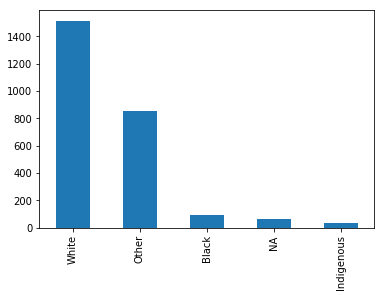

In [105]:
with_race.to_df()['RACE'].value_counts().plot.bar()

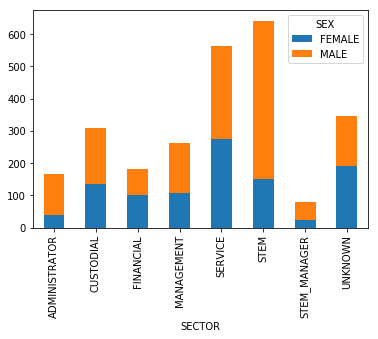

In [106]:
with_race.to_df().groupby(['SECTOR', 'SEX'])['SEX'].count().unstack().plot.bar(stacked=True)

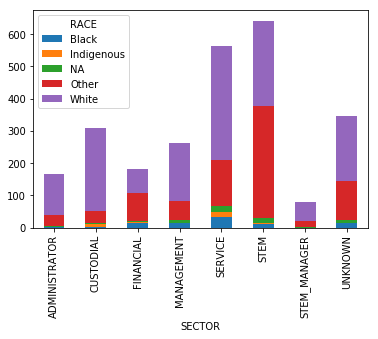

In [107]:
with_race.to_df().groupby(['SECTOR', 'RACE'])['RACE'].count().unstack().plot.bar(stacked=True)

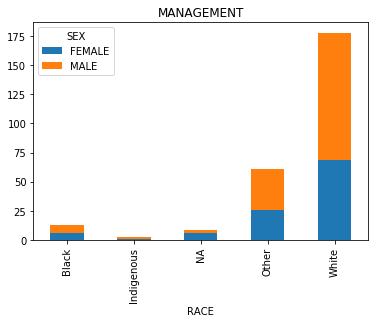

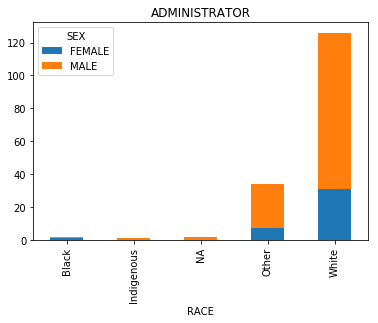

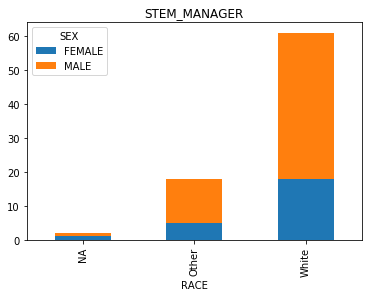

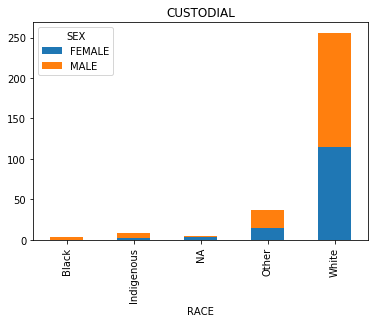

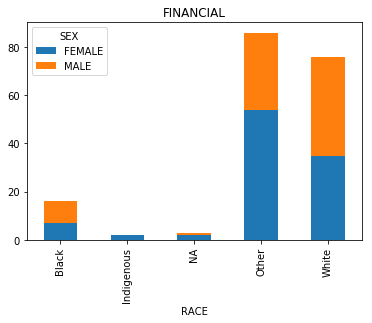

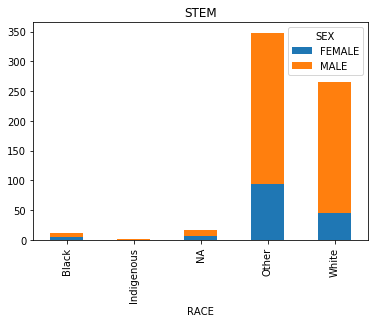

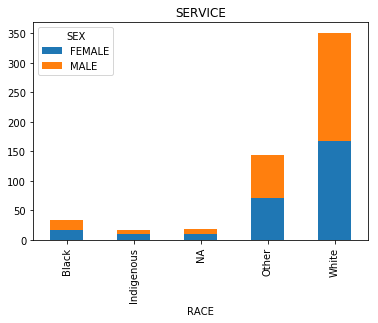

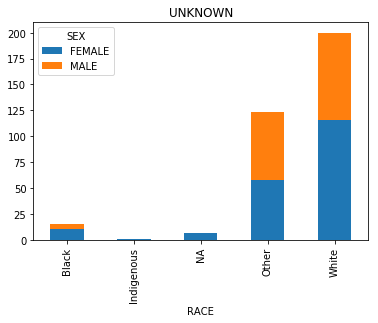

In [206]:
for s in set(sectors):
    df = with_race.to_df()
    df[df['SECTOR'] == s].groupby(['RACE', 'SEX'])['SEX'].count().unstack().plot.bar(stacked=True, title=s)

By looking at the average mean of each part of the sample, we see some differences. 

## Income by race and gender

In [109]:
# the average total income for females vs. males
with_race.to_df().groupby(['SEX'])['INCTOT'].mean()

SEX
FEMALE     57354
MALE      104469
Name: INCTOT, dtype: int64

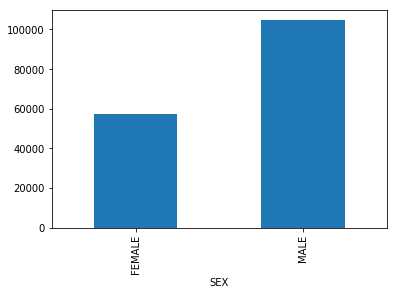

In [110]:
with_race.to_df().groupby(['SEX'])['INCTOT'].mean().plot.bar()

In [111]:
# the average income by race
with_race.to_df().groupby(['RACE'])['INCTOT'].mean()

RACE
Black         68431.408602
Indigenous    35181.969697
NA            63854.098361
Other         85841.176471
White         88473.216127
Name: INCTOT, dtype: float64

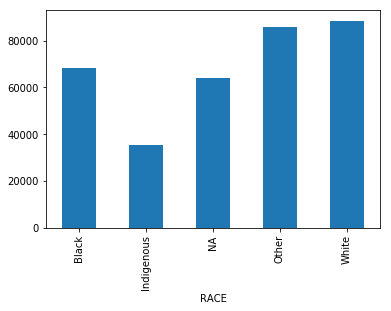

In [112]:
with_race.to_df().groupby(['RACE'])['INCTOT'].mean().plot.bar()

This type of comparison isn't very reliable. We will perform a p-value test to determine if the change of income across races/ sex is statistically significant. To do this we first need to bootstrap our sample to make a 95% confidence interval of the estimated population mean. 

In [113]:
def bootstrap_median(original_sample, label, replications):
    '''
    Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    '''
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)

    return medians

Let's look at `MALE` vs. `FEMALE`:

The median 95% Confidence Interval for MALE is [ 70005.  80000.]
The median 95% Confidence Interval for FEMALE is [ 37000.  41615.]


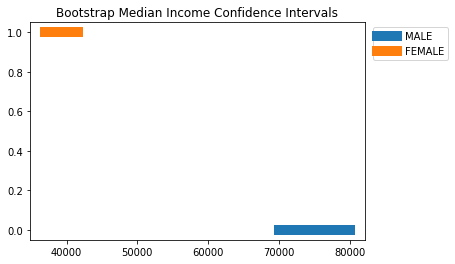

In [114]:
median_dict = {}
for i, s in enumerate(['MALE', 'FEMALE']):
    subset = Table.from_df(df[df['SEX'] == s])
    medians= bootstrap_median(subset, "INCTOT", 1000)
    median_dict[s] = medians
    left = percentile(2.5, medians)
    right = percentile(97.5, medians)
    CI = make_array(left, right)
    print("The median 95% Confidence Interval for " + s + " is", CI)
    plt.plot(CI, make_array(i, i), lw=10, label=s)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.title('Bootstrap Median Income Confidence Intervals')

We can calculate the p-value from the median samples to determine whether the difference is significant:

In [115]:
stats.ttest_ind(median_dict['MALE'], median_dict['FEMALE'])

Ttest_indResult(statistic=390.51181032065642, pvalue=0.0)

We can also look by `RACE`:

The median 95% Confidence Interval for White is [ 42750.  53653.]
The median 95% Confidence Interval for Other is [ 69000.  80000.]
The median 95% Confidence Interval for Indigenous is [ 18003.  35000.]
The median 95% Confidence Interval for NA is [ 36000.  73475.]
The median 95% Confidence Interval for Black is [ 40100.  60645.]


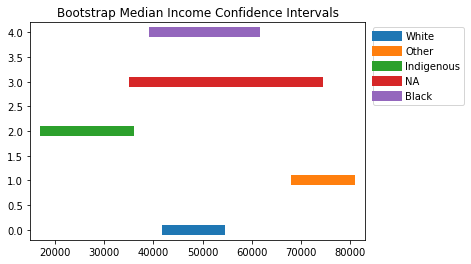

In [116]:
median_dict = {}
for i, r in enumerate(set(df['RACE'])):
    subset = Table.from_df(df[df['RACE'] == r])
    medians= bootstrap_median(subset, "INCTOT", 1000)
    median_dict[r] = medians
    left = percentile(2.5, medians)
    right = percentile(97.5, medians)
    CI = make_array(left, right)
    print("The median 95% Confidence Interval for " + r + " is", CI)
    plt.plot(CI, make_array(i, i), lw=10, label=r)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.title('Bootstrap Median Income Confidence Intervals')

We can do a one way F test to see if there is significance in the difference between the median samples:

In [117]:
stats.f_oneway(median_dict['NA'], median_dict['Other'], median_dict['Indigenous'], median_dict['White'], median_dict['Black'])

F_onewayResult(statistic=11725.961305406679, pvalue=0.0)

We can use a fancy tool to give us all the combinations of `SEX` and `RACE` and then get the confidence intervals for those:

In [118]:
import itertools

combos = [i for i in itertools.product(set(df['RACE']), ['MALE', 'FEMALE'])]
combos

[('White', 'MALE'),
 ('White', 'FEMALE'),
 ('Other', 'MALE'),
 ('Other', 'FEMALE'),
 ('Indigenous', 'MALE'),
 ('Indigenous', 'FEMALE'),
 ('NA', 'MALE'),
 ('NA', 'FEMALE'),
 ('Black', 'MALE'),
 ('Black', 'FEMALE')]

The median 95% Confidence Interval for White MALE is [ 60047.  75000.]
The median 95% Confidence Interval for White FEMALE is [ 27500.  36005.]
The median 95% Confidence Interval for Other MALE is [ 80000.  92000.]
The median 95% Confidence Interval for Other FEMALE is [ 48330.  63610.]
The median 95% Confidence Interval for Indigenous MALE is [ 14000.  43682.]
The median 95% Confidence Interval for Indigenous FEMALE is [ 15000.  35000.]
The median 95% Confidence Interval for NA MALE is [  30000.  101700.]
The median 95% Confidence Interval for NA FEMALE is [ 30000.  69000.]
The median 95% Confidence Interval for Black MALE is [ 38620.  82001.]
The median 95% Confidence Interval for Black FEMALE is [ 32000.  60576.]


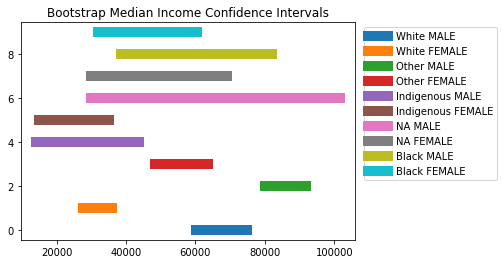

In [119]:
for i, c in enumerate(combos):
    subset = df[df['RACE'] == c[0]]
    subset = Table.from_df(subset[subset['SEX'] == c[1]])
    medians= bootstrap_median(subset, "INCTOT", 1000)
    left = percentile(2.5, medians)
    right = percentile(97.5, medians)
    CI = make_array(left, right)
    print("The median 95% Confidence Interval for " + c[0] + ' ' + c[1] + " is", CI)
    plt.plot(CI, make_array(i, i), lw=10, label=c[0] + ' ' + c[1])
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.title('Bootstrap Median Income Confidence Intervals')

Discuss this plot with the people around you and write a response below.

> Type your response here.

---

## Compared to entire Bay Area census sample

So how does our tech-biased subset compare to the entire census subset of the Bay Area? First we'll do some quick processing to get out non-responses and relabel the Bay Area subset: 

In [120]:
bay_area2 = bay_area.to_df().replace({"RACE": race_dict, "SEX": {1: "MALE", 2: "FEMALE"}})
bay_area2 = bay_area2[bay_area2["INCTOT"] != 0]
bay_area2 = bay_area2[bay_area2["INCTOT"] != 99999999]

Let's check to see what our sample contains in terms of `SEX` and `RACE`:

In [121]:
bay_area2['SEX'].value_counts()

MALE      4575
FEMALE    4466
Name: SEX, dtype: int64

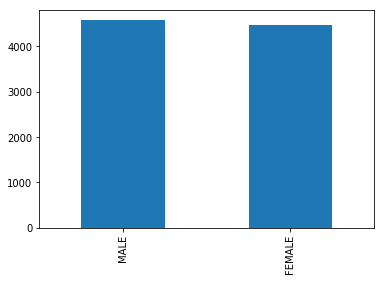

In [122]:
bay_area2['SEX'].value_counts().plot.bar()

In [123]:
bay_area2['RACE'].value_counts()

White         5307
Other         2832
Black          500
NA             267
Indigenous     135
Name: RACE, dtype: int64

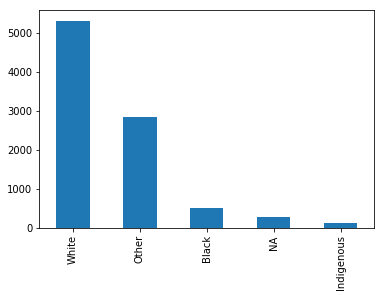

In [124]:
bay_area2['RACE'].value_counts().plot.bar()

We can then look at income by `SEX` and `RACE`. Let's start with `SEX`.

### `SEX`

SEX
FEMALE    45616
MALE      78807
Name: INCTOT, dtype: int64

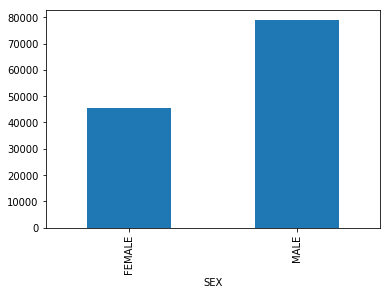

In [125]:
bay_area_mean_sex = bay_area2.groupby(['SEX'])['INCTOT'].mean()
bay_area_mean_sex.plot.bar()
bay_area_mean_sex

We'll recall that our biased subset had much higher means, but similar disparity:

SEX
FEMALE     57354
MALE      104469
Name: INCTOT, dtype: int64

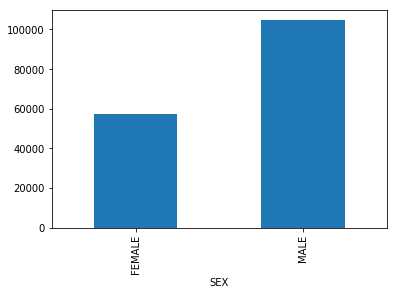

In [73]:
# this plot is the same as the one in the previous section with job codes - copied here for your reference
with_race_mean_sex = with_race.to_df().groupby(['SEX'])['INCTOT'].mean()
with_race_mean_sex.plot.bar()
with_race_mean_sex

UCB is doing much better than both of these subsets:

Gender
FEMALE    158435
MALE      185467
Name: Gross Pay, dtype: int64

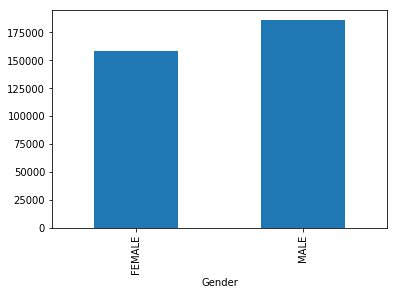

In [74]:
professors_mean_sex = professors.to_df().groupby(['Gender'])['Gross Pay'].mean()
professors_mean_sex.plot.bar()
professors_mean_sex

We can put each of these bar charts together to get a better idea of how the numbers in each of these subsets relate to each other:

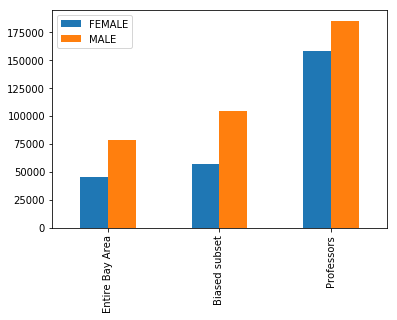

In [75]:
b = pd.DataFrame([bay_area_mean_sex, with_race_mean_sex, professors_mean_sex], ["Entire Bay Area", "Biased subset", "Professors"])
b.plot.bar()

Again, combining the charts in a different way to group the numbers for each gender together:

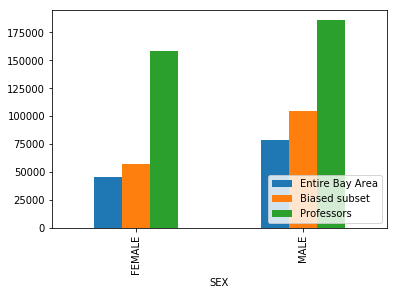

In [76]:
b2 = pd.DataFrame(list(zip(bay_area_mean_sex, with_race_mean_sex, professors_mean_sex)), bay_area_mean_sex.keys())
ax = b2.plot.bar()
ax.legend(["Entire Bay Area", "Biased subset", "Professors"], loc=4)

We can also calculate the differences between average wages of males and females in each of our population subsets. The table below is the complete table with the wages of each gender for each group, which we used in the charts above.

In [77]:
b

,FEMALE,MALE
Entire Bay Area,45616,78807
Biased subset,57354,104469
Professors,158435,185467


To calculate the difference, we subtract the amount of each gender group's wages from each other, and get the numbers below. These numbers represent how much more males earn than females in each group.

In [78]:
b['MALE'] - b['FEMALE']

Entire Bay Area    33191
Biased subset      47115
Professors         27032
dtype: int64

How about `FEMALE` as a percentage of `MALE`?

In [79]:
b['FEMALE'] / b['MALE']

Entire Bay Area    0.578832
Biased subset      0.549005
Professors         0.854249
dtype: float64

### `RACE`
We can also look at `RACE` in the larger Bay Area subset:

In [126]:
bay_area_mean_race = bay_area2.groupby(['RACE'])['INCTOT'].mean()
bay_area_mean_race

RACE
Black         46507.620000
Indigenous    35791.237037
NA            56991.700375
Other         58965.673729
White         66699.061805
Name: INCTOT, dtype: float64

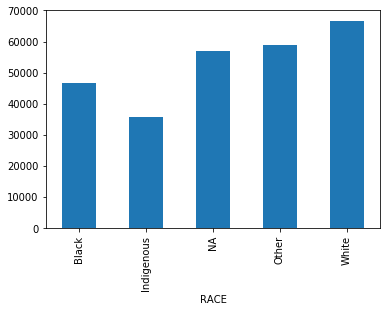

In [127]:
bay_area_mean_race.plot.bar()

Our biased subset was also great here:

In [128]:
with_race_mean_race = with_race.to_df().groupby(['RACE'])['INCTOT'].mean()
with_race_mean_race

RACE
Black         68431.408602
Indigenous    35181.969697
NA            63854.098361
Other         85841.176471
White         88473.216127
Name: INCTOT, dtype: float64

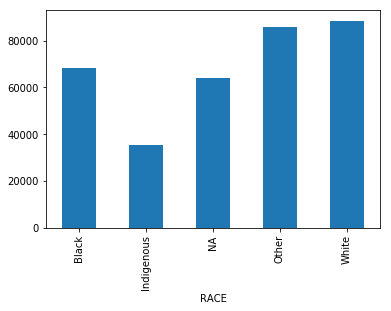

In [129]:
with_race_mean_race.plot.bar()

Again, we'll put these charts together so we can better compare how these different subsets' numbers relate to each other:

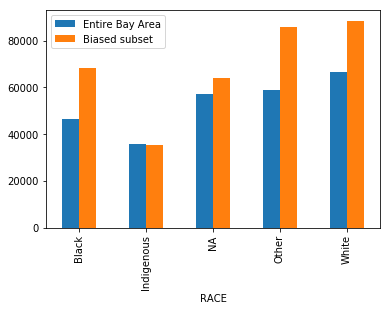

In [59]:
b = pd.DataFrame(list(zip(bay_area_mean_race, with_race_mean_race)), bay_area_mean_race.keys())
ax = b.plot.bar(stacked=False)
ax.legend(["Entire Bay Area", "Biased subset"])

As we noted when we were investigating the data from workers in the Tech industry, it is more helpful to consider race and gender together:

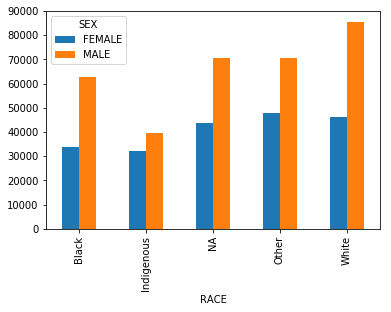

In [201]:
bay_area2.groupby(['RACE', 'SEX'])['INCTOT'].mean().unstack().plot.bar()


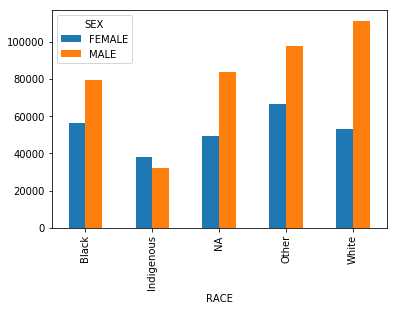

In [205]:
with_race.to_df().groupby(['RACE', 'SEX'])['INCTOT'].mean().unstack().plot.bar()

Where are the disparities the worst?

---

scratch work

In [207]:
b2 = bay_area.copy()
b2 = b2.drop(12).with_column("RACE", list(map(lambda x: race_dict[x], bay_area.column('RACE'))))
b2 = b2.drop(11).with_column("SEX", list(map(lambda x: "MALE" if x==1 else "FEMALE", bay_area.column('SEX'))))
b2 = b2.where("INCTOT", are.not_equal_to(0))
b2 = b2.where("INCTOT", are.not_equal_to(99999999))
b2.select("RACE", "SEX","INCTOT").group(["RACE", "SEX"], np.mean)

RACE,SEX,INCTOT mean
Black,FEMALE,33999.5
Black,MALE,62953.5
Indigenous,FEMALE,32134.8
Indigenous,MALE,39613.8
NA,FEMALE,43686.4
NA,MALE,70599.4
Other,FEMALE,47862.2
Other,MALE,70403.5
White,FEMALE,46112.9
White,MALE,85610.6
